# Clustering (2)

Nella lezione precedente abbiamo visto come calcolare e visualizzare i risultati di un clustering. Tuttavia abbiamo scelto un numero di cluster (3) in maniera "arbitraria", nel senso che conoscevamo già che tre poteva/doveva essere il numero adeguato perché sono tre le specie di pinguini.

Questo approccio non è completo e "robusto" per diverse ragioni. La prima è che solitamente il clustering viene usato quando in un contesto (*setting*) non supervisionato (o *unsupervised*) in cui non è nota la variabile `y` (nel nostro caso, la specie dei pinguini). Il clustering comunque può essere usato in contesti supervisionati (o *supervised*) per ottenere delle "intuizioni" sulle reali divisioni dei dati: nel caso dei nostri pinguini, per esempio, potrebbe farci soffermare sul fatto che esistano (o meno) differenze *statisticamente significative* tra pinguini sulle stesse isole o di diverso sesso.

In altre parole, il numero di "sottogruppi" di pinguini potrebbe essere più di tre: magari addirittura sei (uno per ogni combinazione di sesso e specie) o persino solo quattro o cinque (se, ad esempio, la distinzione tra sesso e specie è statisticamente rilevante solo per una o due specie). Potrebbero esserci anche sottogruppi della stessa specie di pinguini in isole diverse, ad esempio perché le differenti condizioni ambientali ne consentono uno sviluppo diverso. Il kmeans non ci dà strumenti statistici per determinare queste differenze, ma può suggerirci delle dimensioni verso le quali orientare la nostra analisi.

Che cosa significa questo concretamente? Che il numero di cluster è da determinare con una combinazione di metriche e di considerazioni teoriche. Ci sono molte metriche, spiegate molto bene su [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). Purtroppo l'unico metodo per calcolarle è fittare un numero arbitrario di kmeans in un range (ad esempio da 1 a 30) e plottare queste misure per vedere qual è il numero ideale di cluster.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
penguins_raw = (
    pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
        .dropna()
)

penguins = pd.get_dummies(
    penguins_raw.drop("species", axis=1),
    columns=["sex", "island"],
    drop_first=True
)

penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,sex_male,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,2007,1,0,1
1,39.5,17.4,186.0,3800.0,2007,0,0,1
2,40.3,18.0,195.0,3250.0,2007,0,0,1
4,36.7,19.3,193.0,3450.0,2007,0,0,1
5,39.3,20.6,190.0,3650.0,2007,1,0,1


Fittiamo il kmeans con tre cluster, per ripassare la sintassi:

In [3]:
pipeline = make_pipeline(
    StandardScaler(),
    KMeans(random_state=42, n_clusters=3)
)

pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

Possiamo anche costruire una pipeline così, con una sintassi più "verbosa" ma personalizzabile:

In [4]:
pipeline = Pipeline([
        ("Normalizzazione", StandardScaler()),
        ("KMeans", KMeans(n_clusters=3, random_state=42))
])

pipeline

Pipeline(steps=[('Normalizzazione', StandardScaler()),
                ('KMeans', KMeans(n_clusters=3, random_state=42))])

In [5]:
results = pipeline.fit(penguins)

La misura più rapida da calcolare è l'inerzia, che si ottiene direttamente dal modello fittato così:

In [6]:
results[1].inertia_

1339.6125746439232

Per valutare l'inerzia su più cluster, dobbiamo costruire una lista di inerzie per un numero di cluster da 2 (non ci possono essere meno di due cluster) a $n$.

Definiamo qualche funzione per riutilizzare il codice anche più avanti.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_clusters_range(max_clusters):
    return np.arange(2, max_clusters + 1, dtype=np.int8)
    

def compute_inertia(data, max_clusters, random_state=42):
    
    clusters_inertia = []
    
    # conviene normalizzare i dati fuori dalla pipeline
    # per non doverlo fare ogni volta durante il loop
    scaled_data = StandardScaler().fit_transform(data)
    
    for cluster in make_clusters_range(max_clusters):
        
        kmeans = KMeans(random_state=random_state, n_clusters=cluster)
        results = kmeans.fit(scaled_data)
        
        clusters_inertia.append(results[1].inertia_)
        
    return np.array(clusters_inertia)


def plot_inertia(inertia, max_clusters):
    
    cluster_range = make_clusters_range(max_clusters)
    
    fig, ax = plt.subplots(figsize=(12,8))

    ax.plot(cluster_range, inertia)
    ax.scatter(cluster_range, inertia)
    
    ax.set(title=f"Inertia for {max_clusters} clusters (lower is better)", xticks=cluster_range)
    
    plt.show()


def inertia_pipeline(data, max_clusters, random_state):
    inertia = compute_inertia(data=data, max_clusters=max_clusters, random_state=random_state)
    
    plot_inertia(inertia, max_clusters)

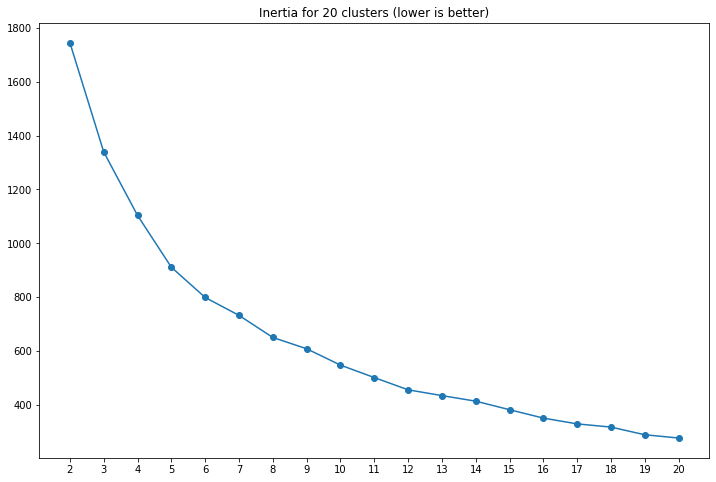

In [17]:
inertia_pipeline(penguins, max_clusters=20, random_state=42)

*Qualsiasi* metrica ci dirà che più cluster sono meglio. Nel caso dell'inerzia, *lower is better*. Il punto è che si arriva paradossalmente alla situazione in cui l'inerzia sarebbe minima quando il numero di cluster equivale a quello di osservazioni. Questo è chiaramente inutile. Solitamente, l'euristica (cioè la prassi) è di scegliere il numero di cluster attorno al quale la misura smette di crescere in maniera importante. Chiaramente la soglia per cui "smette di crescere" è abbastanza arbitraria. In questo caso, potrebbe essere tra i 3 e i 5/6 cluster. Per aiutarci, possiamo ricorrere a più metriche:

In [42]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


def compute_cluster_metrics(source_data, num_clusters, random_state):
    kmeans = KMeans(num_clusters, random_state=random_state).fit(source_data)

    inertia = kmeans.inertia_
    davies_bouldin = davies_bouldin_score(source_data, kmeans.labels_)
    silhouette_coefficient = silhouette_score(source_data, kmeans.labels_, metric="euclidean")
    calinski_harabasz = calinski_harabasz_score(source_data, kmeans.labels_)

    return inertia, davies_bouldin, silhouette_coefficient, calinski_harabasz


def compute_metrics(data, max_clusters, random_state):
    scaled_data = StandardScaler().fit_transform(data)

    clusters_range = make_clusters_range(max_clusters)

    metrics_list = [compute_cluster_metrics(scaled_data, k, random_state) for k in clusters_range]

    metrics = pd.DataFrame(
        metrics_list,
        index=clusters_range,
        columns=["inertia", "davies_bouldin", "silhouette_coefficient", "calinski_harabasz"]
    )

    metrics.index.name = "number_of_clusters"

    return metrics


def plot_metrics(metrics: pd.DataFrame):
    
    def plot_metric(metrics, col, ax):
        
        if col == "inertia" or col == "davies_bouldin":
            plot_title = f"{col.replace('_', ' ').title()} (lower is better)"
        else:
            plot_title = f"{col.replace('_', ' ').title()} (higher is better)"
        
        ax.plot(metrics[col])
        ax.scatter(metrics.index, metrics[col])
        ax.set(title=f"{plot_title}", xticks=metrics.index)

    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    
    for ax, metric in zip(ax.reshape(-1), metrics.columns):
        plot_metric(metrics, metric, ax)
        

def metrics_pipeline(data, max_clusters, random_state):
    metrics = compute_metrics(data=data, max_clusters=max_clusters, random_state=random_state)
    
    plot_metrics(metrics)

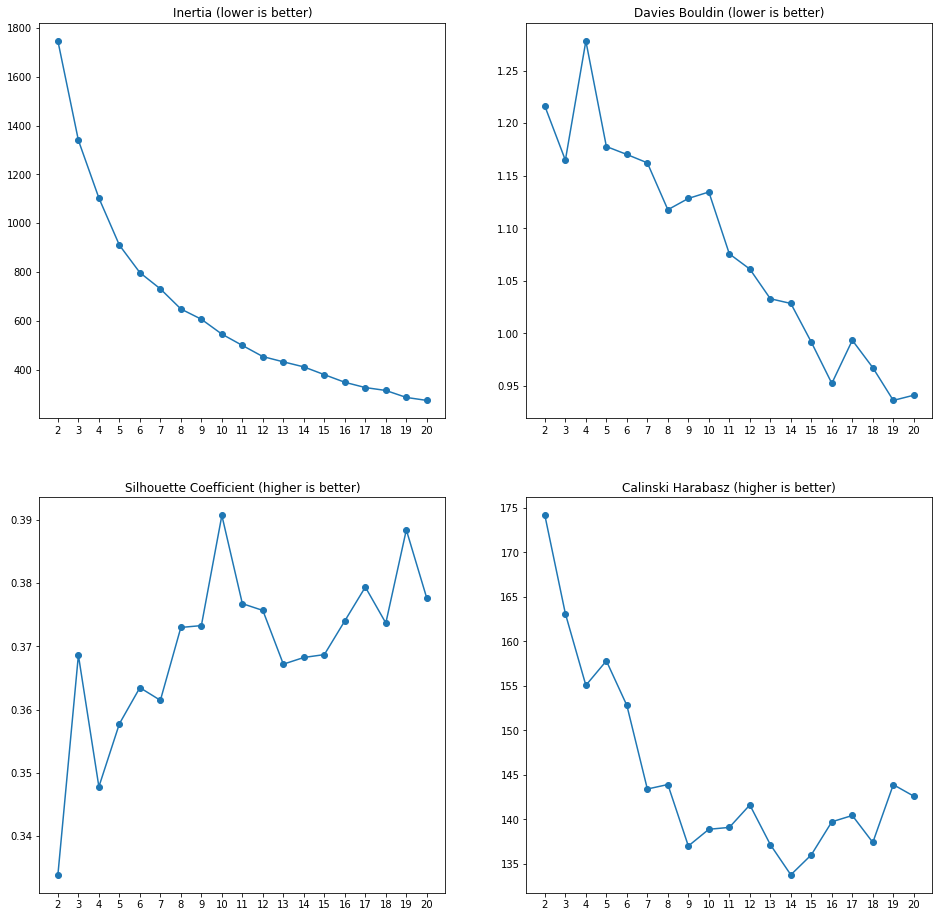

In [43]:
metrics_pipeline(data=penguins, max_clusters=20, random_state=42)

Ci sono varie note sulle metriche da usare:

1. Alcune metriche richiedono che le classi siano note. Quelle usate sono alcune metriche quando le variabili non lo sono.
2. Le metriche hanno degli usi, dei pro e dei contro. Ad esempio, il Calinski-Harabasz funziona per i cluster convessi (cioè delle forme chiuse e isolate) e quindi non è affidabile se i dati sono disposti ad esempio a spirale.
3. Le metriche possonoe essere discordanti. Il silhouette coefficient suggerirebbe 10 cluster, mentre il Calinski-Harabasz meno di 5.